# 04. PPO 에이전트 학습

**목표:** Stable-Baselines3의 PPO 알고리즘으로 트레이딩 에이전트 학습

```
[ 입력 ]  data/processed/train.csv, val.csv
          src/env/trading_env.py
[ 출력 ]  models/ppo_btc_trader.zip  (학습된 모델)
          models/logs/               (학습 로그)
```

## 1. 라이브러리 확인 및 Import

In [39]:
# 필요 시 설치
# !pip install stable-baselines3 tensorboard

OS: Windows
폰트: ['Malgun Gothic']


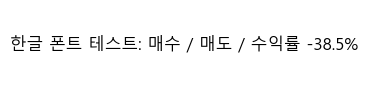

In [40]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ─────────────────────────────────────────────
#  OS별 한글 폰트 자동 설정
# ─────────────────────────────────────────────
def set_korean_font():
    system = platform.system()
    
    if system == 'Windows':
        # Windows: 맑은 고딕
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif system == 'Darwin':
        # Mac: 애플 고딕
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        # Linux (Colab 등): NanumGothic 설치 필요
        import subprocess
        subprocess.run(['apt-get', 'install', '-y', 'fonts-nanum'], 
                      capture_output=True)
        fm._load_fontmanager(try_read_cache=False)
        plt.rcParams['font.family'] = 'NanumGothic'
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    
    print(f"OS: {system}")
    print(f"폰트: {plt.rcParams['font.family']}")

set_korean_font()

# 폰트 적용 테스트
fig, ax = plt.subplots(figsize=(4, 1))
ax.text(0.5, 0.5, '한글 폰트 테스트: 매수 / 매도 / 수익률 -38.5%', 
        ha='center', va='center', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

In [41]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings('ignore')

# 환경 모듈 경로 추가
sys.path.append('../src')
from env import BTCTradingEnv

# Stable-Baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from stable_baselines3.common.callbacks import (
    EvalCallback,
    CallbackList,
    BaseCallback,
)
from stable_baselines3.common.monitor import Monitor

import stable_baselines3 as sb3
print(f"stable-baselines3 : {sb3.__version__}")
print(f"PyTorch           : {torch.__version__}")
print(f"CUDA 사용 가능    : {torch.cuda.is_available()}")
print(f"GPU               : {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

stable-baselines3 : 2.7.1
PyTorch           : 2.10.0+cu128
CUDA 사용 가능    : True
GPU               : NVIDIA GeForce RTX 4060 Laptop GPU


## 2. 데이터 및 경로 설정

In [42]:
# 경로 설정
PROCESSED_DIR = '../data/processed'
MODEL_DIR     = '../models'
LOG_DIR       = '../models/logs'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# 데이터 로드
def load_data(name):
    path = os.path.join(PROCESSED_DIR, f'{name}.csv')
    return pd.read_csv(path, index_col=0, parse_dates=True)

df_train = load_data('train')
df_val   = load_data('val')

print(f"Train : {len(df_train):,}행 x {len(df_train.columns)}열")
print(f"Val   : {len(df_val):,}행 x {len(df_val.columns)}열")

Train : 47,836행 x 38열
Val   : 6,401행 x 38열


## 3. 하이퍼파라미터 설정

PPO 주요 하이퍼파라미터 설명:

| 파라미터 | 의미 | 권장 범위 |
|---|---|---|
| `learning_rate` | 학습률 | 1e-5 ~ 3e-4 |
| `n_steps` | 정책 업데이트 전 수집할 스텝 수 | 1024 ~ 4096 |
| `batch_size` | 미니배치 크기 | 64 ~ 512 |
| `n_epochs` | 수집된 데이터로 몇 번 학습할지 | 5 ~ 20 |
| `gamma` | 미래 보상 할인율 | 0.95 ~ 0.999 |
| `clip_range` | PPO 클리핑 범위 | 0.1 ~ 0.3 |
| `ent_coef` | 탐색 장려 엔트로피 계수 | 0.0 ~ 0.01 |

In [43]:
# ─────────────────────────────────────────────
#  하이퍼파라미터 (여기서 조정)
# ─────────────────────────────────────────────
CONFIG = {
    # 환경 설정
    'initial_balance' : 10_000.0,
    'fee_rate'        : 0.0005,

    # PPO 하이퍼파라미터
    'learning_rate'   : 1e-4,
    'n_steps'         : 4096,       # 업데이트 전 수집 스텝
    'batch_size'      : 256,
    'n_epochs'        : 5,
    'gamma'           : 0.99,       # 할인율
    'gae_lambda'      : 0.95,       # GAE lambda
    'clip_range'      : 0.1,
    'ent_coef'        : 0.001,      # 탐색 장려
    'vf_coef'         : 0.5,        # Value function 계수
    'max_grad_norm'   : 0.5,

    # 환경 파라미터 수정
    'trade_threshold' : 0.05,
    'position_penalty' : 0.005,

    # 신경망 구조
    'net_arch'        : [256, 256], # Actor/Critic 각각 256-256
    
    # 학습 설정
    'total_timesteps' : 1_000_000,  # 총 학습 스텝 (처음엔 100만으로 시작)
    'eval_freq'       : 10_000,     # 몇 스텝마다 검증할지
    'n_eval_episodes' : 1,
}

print("하이퍼파라미터 설정 완료")
for k, v in CONFIG.items():
    print(f"  {k:<20} : {v}")

하이퍼파라미터 설정 완료
  initial_balance      : 10000.0
  fee_rate             : 0.0005
  learning_rate        : 0.0001
  n_steps              : 4096
  batch_size           : 256
  n_epochs             : 5
  gamma                : 0.99
  gae_lambda           : 0.95
  clip_range           : 0.1
  ent_coef             : 0.001
  vf_coef              : 0.5
  max_grad_norm        : 0.5
  trade_threshold      : 0.05
  position_penalty     : 0.005
  net_arch             : [256, 256]
  total_timesteps      : 1000000
  eval_freq            : 10000
  n_eval_episodes      : 1


## 4. 커스텀 콜백 정의

학습 중 Validation 성과를 실시간으로 추적하기 위한 콜백입니다.

In [44]:
class TradingMetricsCallback(BaseCallback):
    """
    학습 중 Validation 환경에서 트레이딩 성과 지표를 기록하는 콜백
    - 총 수익률
    - 샤프 지수
    - 최대 낙폭 (MDD)
    - 거래 횟수
    """
    
    def __init__(self, eval_env, eval_freq=10_000, verbose=1):
        super().__init__(verbose)
        self.eval_env  = eval_env
        self.eval_freq = eval_freq
        
        # 기록용 리스트
        self.timesteps      = []
        self.total_returns  = []
        self.sharpe_ratios  = []
        self.max_drawdowns  = []
        self.trade_counts   = []
        self.best_return    = -np.inf
    
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # Validation 환경에서 전체 에피소드 실행
            obs, _ = self.eval_env.reset()
            done   = False
            
            while not done:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, _, terminated, truncated, info = self.eval_env.step(action)
                done = terminated or truncated
            
            # 성과 지표 계산
            pv       = np.array(self.eval_env.portfolio_values)
            returns  = np.diff(pv) / (pv[:-1] + 1e-9)
            
            total_ret = (pv[-1] - self.eval_env.initial_balance) / self.eval_env.initial_balance * 100
            sharpe    = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(24 * 365)
            roll_max  = np.maximum.accumulate(pv)
            max_dd    = ((roll_max - pv) / (roll_max + 1e-9)).max() * 100
            n_trades  = self.eval_env.trade_count
            
            # 기록
            self.timesteps.append(self.num_timesteps)
            self.total_returns.append(total_ret)
            self.sharpe_ratios.append(sharpe)
            self.max_drawdowns.append(max_dd)
            self.trade_counts.append(n_trades)
            
            # 최고 성과 모델 저장
            if total_ret > self.best_return:
                self.best_return = total_ret
                self.model.save(os.path.join(MODEL_DIR, 'ppo_best'))
            
            if self.verbose:
                print(f"[{self.num_timesteps:>8,} steps] "
                      f"수익률: {total_ret:>+7.2f}% | "
                      f"샤프: {sharpe:>6.3f} | "
                      f"MDD: {max_dd:>6.2f}% | "
                      f"거래: {n_trades:>5}회 | "
                      f"최고: {self.best_return:>+7.2f}%")
        
        return True  # False 반환 시 학습 중단
    
    def plot_training_curve(self):
        """학습 완료 후 성과 곡선 시각화"""
        if not self.timesteps:
            print("기록된 데이터가 없습니다.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        
        axes[0,0].plot(self.timesteps, self.total_returns, color='#627EEA', linewidth=1.5)
        axes[0,0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
        axes[0,0].set_title('Val 총 수익률 (%)')
        axes[0,0].set_xlabel('Timesteps')
        axes[0,0].grid(alpha=0.3)
        
        axes[0,1].plot(self.timesteps, self.sharpe_ratios, color='#2ECC71', linewidth=1.5)
        axes[0,1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
        axes[0,1].axhline(1.5, color='green', linestyle=':', linewidth=0.8, label='목표 1.5')
        axes[0,1].set_title('Val 샤프 지수')
        axes[0,1].set_xlabel('Timesteps')
        axes[0,1].legend()
        axes[0,1].grid(alpha=0.3)
        
        axes[1,0].plot(self.timesteps, self.max_drawdowns, color='#E74C3C', linewidth=1.5)
        axes[1,0].axhline(20, color='red', linestyle=':', linewidth=0.8, label='경계 20%')
        axes[1,0].set_title('Val 최대 낙폭 MDD (%)')
        axes[1,0].set_xlabel('Timesteps')
        axes[1,0].legend()
        axes[1,0].grid(alpha=0.3)
        
        axes[1,1].plot(self.timesteps, self.trade_counts, color='#F39C12', linewidth=1.5)
        axes[1,1].set_title('Val 총 거래 횟수')
        axes[1,1].set_xlabel('Timesteps')
        axes[1,1].grid(alpha=0.3)
        
        plt.suptitle('PPO 학습 곡선 (Validation)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(MODEL_DIR, 'training_curve.png'), dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\n최종 성과 (Val)")
        print(f"  최고 수익률  : {max(self.total_returns):>+.2f}%")
        print(f"  최고 샤프    : {max(self.sharpe_ratios):>.3f}")
        print(f"  최저 MDD     : {min(self.max_drawdowns):>.2f}%")

print("콜백 클래스 정의 완료")

콜백 클래스 정의 완료


In [45]:
class EarlyStoppingCallback(BaseCallback):
    """
    Val 수익률이 N번 연속 개선되지 않으면 학습 중단
    """
    def __init__(self, metrics_callback, patience=10, verbose=1):
        super().__init__(verbose)
        self.metrics_callback = metrics_callback
        self.patience         = patience
        self.no_improve_count = 0
        self.best_return      = -np.inf

    def _on_step(self) -> bool:
        returns = self.metrics_callback.total_returns
        if not returns:
            return True

        current = returns[-1]
        if current > self.best_return:
            self.best_return      = current
            self.no_improve_count = 0
        else:
            self.no_improve_count += 1

        if self.no_improve_count >= self.patience:
            if self.verbose:
                print(f"\n🛑 Early Stopping: {self.patience}회 연속 개선 없음 "
                      f"(최고: {self.best_return:+.2f}%)")
            return False  # 학습 중단

        return True

## 5. 환경 생성

In [46]:
# 학습 환경 (VecEnv로 래핑 - SB3 필수)
def make_train_env():
    env = BTCTradingEnv(
        df=df_train,
        initial_balance=CONFIG['initial_balance'],
        fee_rate=CONFIG['fee_rate'],
        trade_threshold=CONFIG['trade_threshold'],   
        position_penalty=CONFIG['position_penalty'], 
    )
    env = Monitor(env)  # 에피소드 보상/길이 자동 기록
    return env

# DummyVecEnv: 단일 환경 (멀티프로세스 필요 시 SubprocVecEnv로 교체)
train_env = DummyVecEnv([make_train_env])

# Validation 환경 (단일 환경)
eval_env = BTCTradingEnv(
    df=df_val,
    initial_balance=CONFIG['initial_balance'],
    fee_rate=CONFIG['fee_rate'],
)

print("✅ 환경 생성 완료")
print(f"  Train 환경 : {len(df_train):,} 스텝")
print(f"  Val 환경   : {len(df_val):,} 스텝")

✅ 환경 생성 완료
  Train 환경 : 47,836 스텝
  Val 환경   : 6,401 스텝


## 6. PPO 모델 정의

In [47]:
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"학습 디바이스: {device}")

# PPO 모델 생성
model = PPO(
    policy='MlpPolicy',             # MLP 기반 정책 (피처 벡터 입력)
    env=train_env,
    learning_rate=CONFIG['learning_rate'],
    n_steps=CONFIG['n_steps'],
    batch_size=CONFIG['batch_size'],
    n_epochs=CONFIG['n_epochs'],
    gamma=CONFIG['gamma'],
    gae_lambda=CONFIG['gae_lambda'],
    clip_range=CONFIG['clip_range'],
    ent_coef=CONFIG['ent_coef'],
    vf_coef=CONFIG['vf_coef'],
    max_grad_norm=CONFIG['max_grad_norm'],
    policy_kwargs={
        'net_arch': CONFIG['net_arch'],
        'activation_fn': torch.nn.ReLU,
    },
    tensorboard_log=LOG_DIR,        # TensorBoard 로그
    device=device,
    verbose=0,                      # 콜백에서 직접 출력하므로 0
    seed=42,
)

# 모델 구조 확인
print(f"\n모델 구조:")
print(model.policy)
print(f"\n총 파라미터 수: {sum(p.numel() for p in model.policy.parameters()):,}개")

학습 디바이스: cuda

모델 구조:
ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=40, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
  )
  (action_net): Linear(in_features=256, out_features=1, bias=True)
  (value_net): Linear(in_features=256, out_features=1, bias=True)
)

총 파라미터 수: 153,091개


## 7. 학습 실행

> ⏱️ `total_timesteps=1_000_000` 기준 RTX 4060 GPU로 약 **10~20분** 소요  
> 학습 중간에 Val 성과가 출력됩니다.

In [48]:
# 콜백 설정
metrics_callback  = TradingMetricsCallback(eval_env=eval_env, eval_freq=10_000)
stopping_callback = EarlyStoppingCallback(metrics_callback, patience=20)

print("=" * 65)
print(f"  PPO 학습 시작")
print(f"  총 스텝    : {CONFIG['total_timesteps']:,}")
print(f"  평가 주기  : {CONFIG['eval_freq']:,} 스텝마다")
print(f"  디바이스   : {device}")
print("=" * 65)

model.learn(
    total_timesteps=CONFIG['total_timesteps'],
    callback=metrics_callback,
    tb_log_name='PPO_BTC',
    reset_num_timesteps=True,
    progress_bar=False,
)

print("\n✅ 학습 완료!")

  PPO 학습 시작
  총 스텝    : 1,000,000
  평가 주기  : 10,000 스텝마다
  디바이스   : cuda
[  10,000 steps] 수익률:  +61.11% | 샤프:  2.936 | MDD:  11.00% | 거래:    14회 | 최고:  +61.11%
[  20,000 steps] 수익률:  +54.57% | 샤프:  2.819 | MDD:  10.72% | 거래:     5회 | 최고:  +61.11%
[  30,000 steps] 수익률:  +56.36% | 샤프:  2.881 | MDD:  10.78% | 거래:    27회 | 최고:  +61.11%
[  40,000 steps] 수익률:  +54.91% | 샤프:  2.807 | MDD:  10.92% | 거래:     9회 | 최고:  +61.11%
[  50,000 steps] 수익률:  +55.81% | 샤프:  2.884 | MDD:  10.79% | 거래:    15회 | 최고:  +61.11%
[  60,000 steps] 수익률:  +56.21% | 샤프:  2.867 | MDD:  10.49% | 거래:    24회 | 최고:  +61.11%
[  70,000 steps] 수익률:  +50.22% | 샤프:  2.832 | MDD:  10.43% | 거래:    99회 | 최고:  +61.11%
[  80,000 steps] 수익률:  +45.13% | 샤프:  2.708 | MDD:  10.04% | 거래:   145회 | 최고:  +61.11%
[  90,000 steps] 수익률:  +45.85% | 샤프:  2.721 | MDD:   9.90% | 거래:   199회 | 최고:  +61.11%
[ 100,000 steps] 수익률:  +45.02% | 샤프:  2.706 | MDD:   9.89% | 거래:   253회 | 최고:  +61.11%
[ 110,000 steps] 수익률:  +44.17% | 샤프:  2.657 | MDD:   9.75

## 8. 학습 곡선 시각화

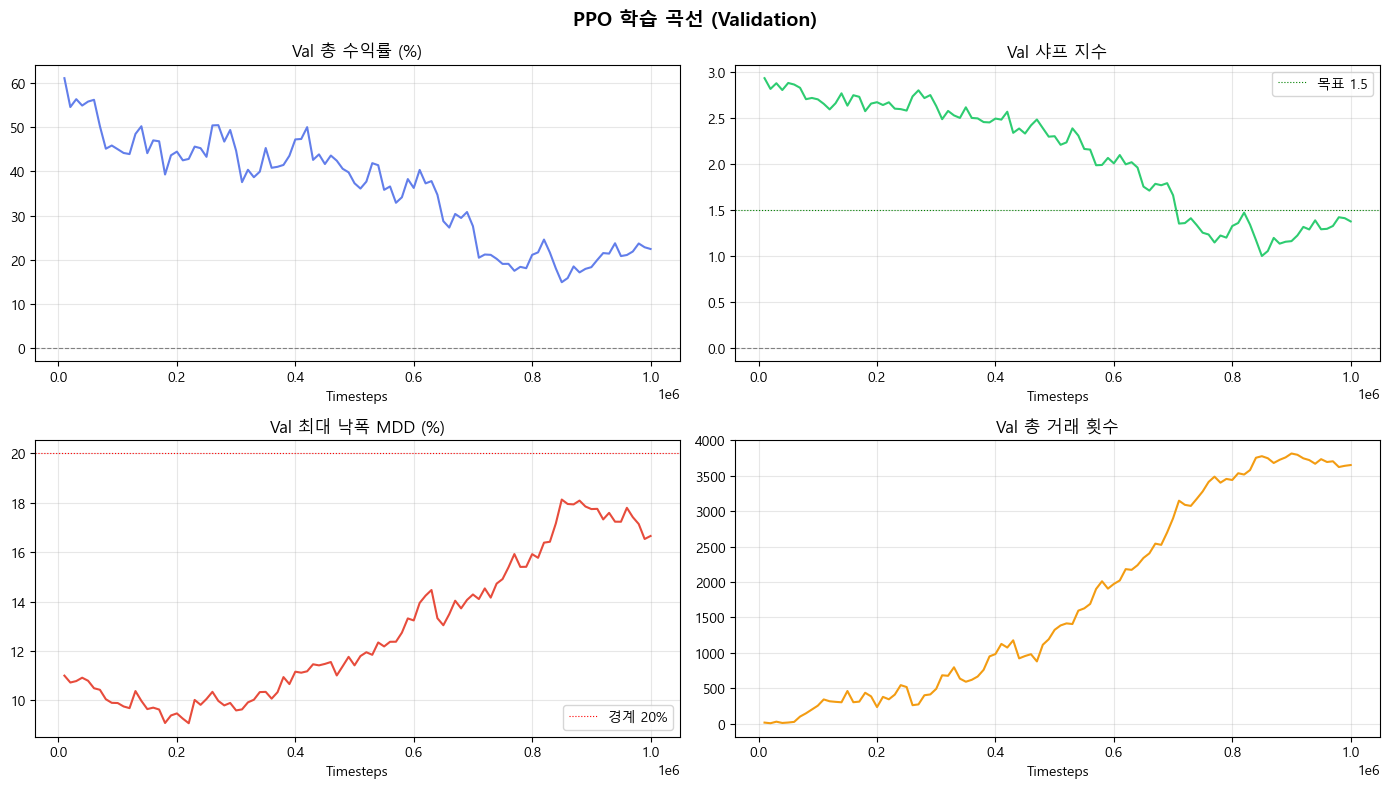


최종 성과 (Val)
  최고 수익률  : +61.11%
  최고 샤프    : 2.936
  최저 MDD     : 9.07%


In [49]:
metrics_callback.plot_training_curve()

## 9. 최종 모델 저장

In [50]:
# 최종 모델 저장 (학습 마지막 체크포인트)
final_model_path = os.path.join(MODEL_DIR, 'ppo_final')
model.save(final_model_path)

print("✅ 모델 저장 완료")
print(f"  최종 모델 : {final_model_path}.zip")
print(f"  최고 모델 : {MODEL_DIR}/ppo_best.zip")

✅ 모델 저장 완료
  최종 모델 : ../models\ppo_final.zip
  최고 모델 : ../models/ppo_best.zip


## 10. 학습된 모델로 Val 성과 최종 확인

최고 성과 모델 로드 완료

[최고 모델 - Validation 성과]


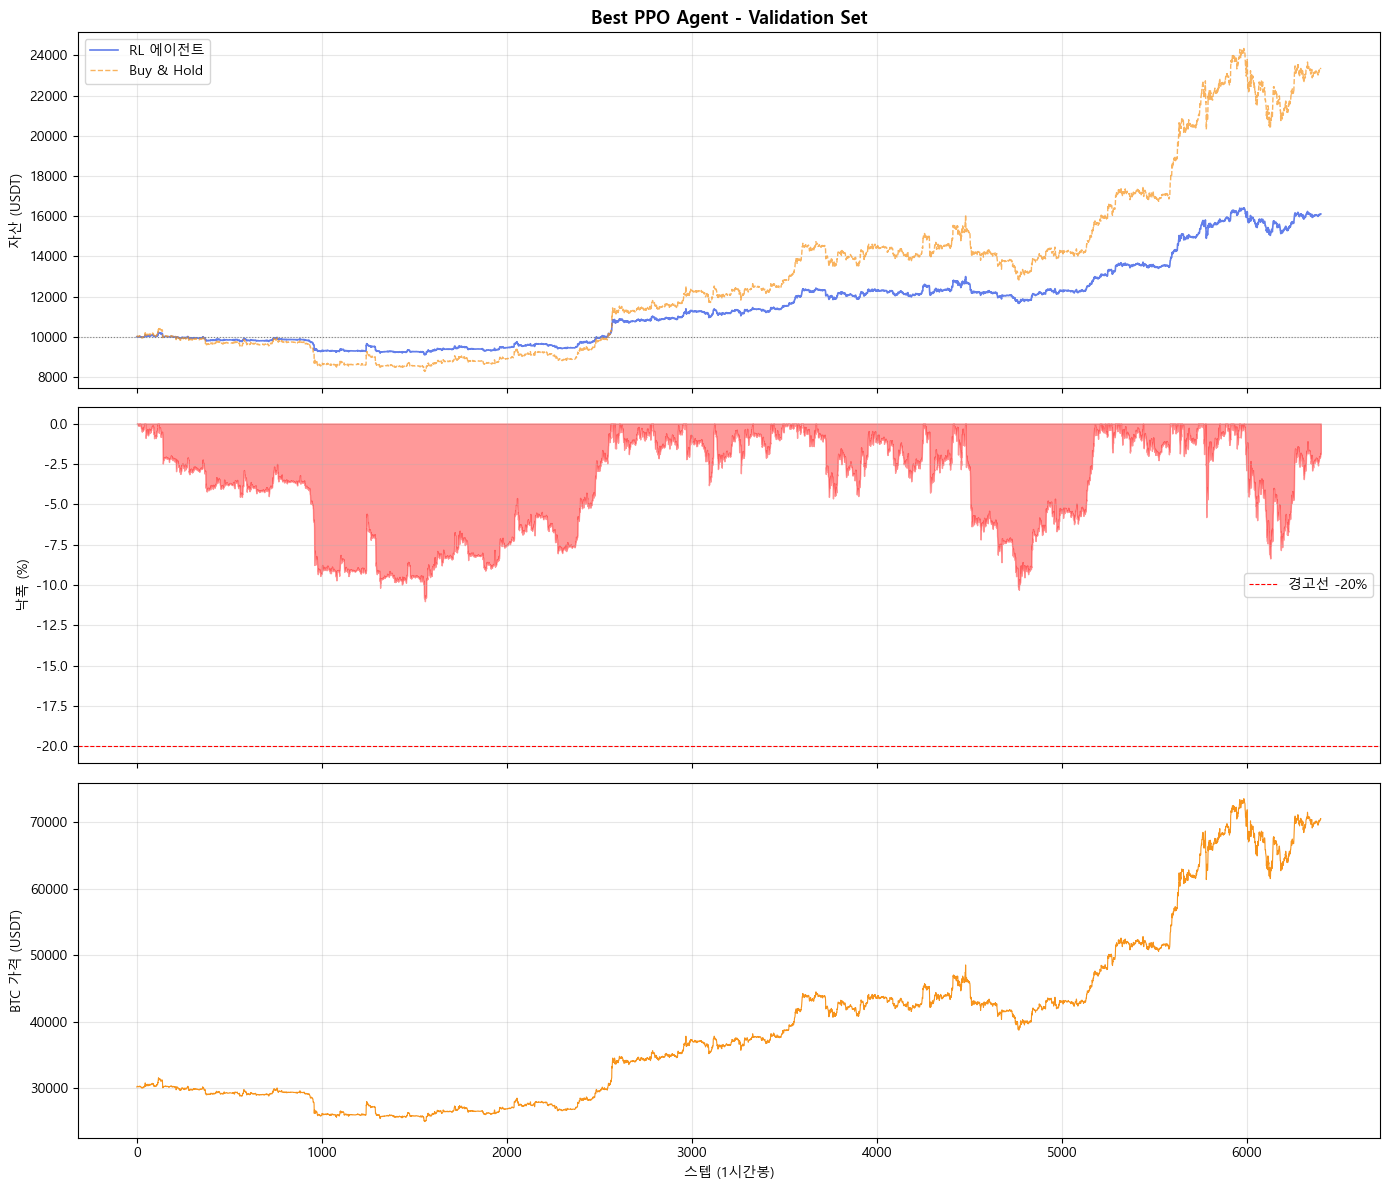


  📊 성과 요약
  최종 자산        : $   16,111.15
  총 수익률        :     +61.11%
  Buy & Hold       :    +133.37%
  알파             :     -72.26%p
---------------------------------------------
  샤프 지수        :      2.936
  최대 낙폭 (MDD)  :      11.00%
  승률             :      51.52%
---------------------------------------------
  총 거래 횟수     :         14회
  총 수수료        : $       6.94


In [51]:
# 최고 성과 모델 로드
best_model = PPO.load(os.path.join(MODEL_DIR, 'ppo_best'), device=device)
print("최고 성과 모델 로드 완료")

# Val 환경에서 전체 에피소드 실행
eval_env_final = BTCTradingEnv(
    df=df_val,
    initial_balance=CONFIG['initial_balance'],
    fee_rate=CONFIG['fee_rate'],
)

obs, _ = eval_env_final.reset()
done   = False

while not done:
    action, _ = best_model.predict(obs, deterministic=True)
    obs, _, terminated, truncated, info = eval_env_final.step(action)
    done = terminated or truncated

print("\n[최고 모델 - Validation 성과]")
eval_env_final.render_performance(title='Best PPO Agent - Validation Set')

## 11. 액션 분포 분석

에이전트가 어떤 액션을 주로 선택하는지 분포를 확인합니다.  
특정 방향으로 치우쳐 있으면 탐색이 부족한 것일 수 있습니다.

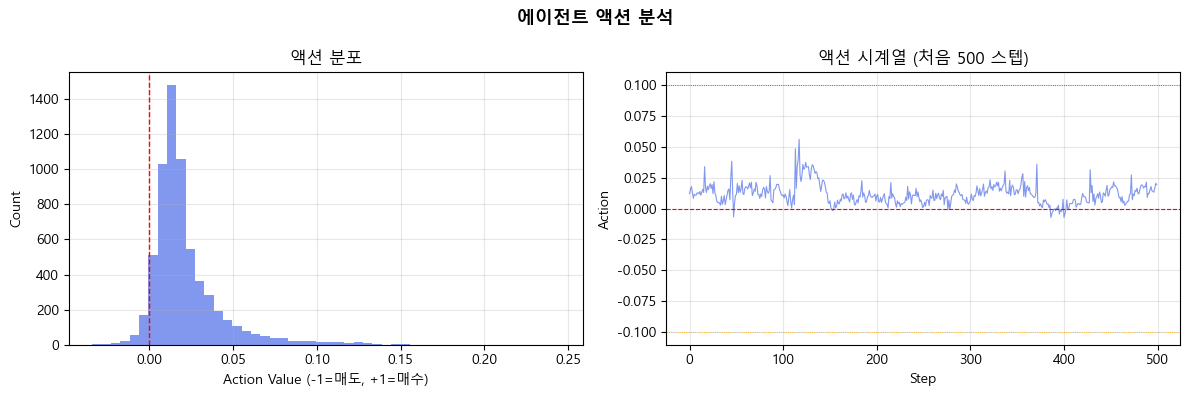

액션 통계
  평균  : +0.0214
  표준편차: 0.0213
  매수(>0.1) 비율 : 1.5%
  홀드(-0.1~0.1)  : 98.5%
  매도(<-0.1) 비율: 0.0%


In [52]:
# 액션 분포 수집
eval_env_action = BTCTradingEnv(df=df_val, initial_balance=CONFIG['initial_balance'])
obs, _ = eval_env_action.reset()
done   = False
actions_taken = []

while not done:
    action, _ = best_model.predict(obs, deterministic=True)
    actions_taken.append(float(action[0]))
    obs, _, terminated, truncated, _ = eval_env_action.step(action)
    done = terminated or truncated

actions_arr = np.array(actions_taken)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 히스토그램
axes[0].hist(actions_arr, bins=50, color='#627EEA', alpha=0.8, edgecolor='none')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('액션 분포')
axes[0].set_xlabel('Action Value (-1=매도, +1=매수)')
axes[0].set_ylabel('Count')
axes[0].grid(alpha=0.3)

# 시간에 따른 액션 변화
axes[1].plot(actions_arr[:500], color='#627EEA', linewidth=0.8, alpha=0.8)
axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8)
axes[1].axhline(0.1, color='green', linestyle=':', linewidth=0.6)
axes[1].axhline(-0.1, color='orange', linestyle=':', linewidth=0.6)
axes[1].set_title('액션 시계열 (처음 500 스텝)')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Action')
axes[1].grid(alpha=0.3)

plt.suptitle('에이전트 액션 분석', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'action_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"액션 통계")
print(f"  평균  : {actions_arr.mean():>+.4f}")
print(f"  표준편차: {actions_arr.std():.4f}")
print(f"  매수(>0.1) 비율 : {(actions_arr > 0.1).mean()*100:.1f}%")
print(f"  홀드(-0.1~0.1)  : {(np.abs(actions_arr) <= 0.1).mean()*100:.1f}%")
print(f"  매도(<-0.1) 비율: {(actions_arr < -0.1).mean()*100:.1f}%")

---

## ✅ 완료 요약

| 항목 | 내용 | 상태 |
|---|---|---|
| PPO 모델 학습 | 100만 스텝 | ✅ |
| Val 중간 평가 | 1만 스텝마다 성과 기록 | ✅ |
| 학습 곡선 저장 | models/training_curve.png | ✅ |
| 최고 모델 저장 | models/ppo_best.zip | ✅ |
| 최종 모델 저장 | models/ppo_final.zip | ✅ |
| 액션 분포 분석 | models/action_distribution.png | ✅ |

**다음 단계:** `05_backtest.ipynb` — Test 데이터로 최종 백테스트 및 성과 분석

### 성과 해석 가이드

학습 후 아래 기준으로 모델 품질을 판단합니다.

| 지표 | 개선 필요 | 양호 | 우수 |
|---|---|---|---|
| 샤프 지수 | < 0.5 | 0.5 ~ 1.5 | > 1.5 |
| MDD | > 30% | 15~30% | < 15% |
| Buy&Hold 대비 | 하회 | 유사 | 상회 |
| 매수/매도/홀드 비율 | 한쪽 치우침 | 균형 | 시장 상황 반응 |